# Notebook 5: Nondeterministic Finite Automata


In [ ]:
#@title Setup
!pip install -qqq tock
from tock import *
!test -x /content/theory || git clone --quiet https://github.com/ND-CSE-30151/spring-2023 /content/theory
%cd -q /content/theory/notes

     |████████████████████████████████| 535 kB 7.4 MB/s 


<div class="alert alert-info">
    <p><b>Read</b> 1.2.</p>
</div>

A deterministic finite automaton always knows what to do because there is always exactly one possible transition for each state $q$ and symbol $a$. Today, we look at *nondeterministic* finite automata (NFAs), in which there might be more than one possible transition. When this happens, the automaton follows *all* the transitions at once. It's a little like the `fork()` system call. Nondeterminism seems like a weird concept at first, but we will come back to it repeatedly throughout the course.

## By example

Here's an example NFA:

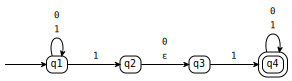

In [ ]:
n1 = read_csv('nfa-n1.csv')
to_graph(n1)

There are two differences to note. First, a state can have more than one transition with the same symbol, or no transition with a certain symbol. Second, a transition can be labeled $\varepsilon$, meaning that the NFA can "spontaneously" follow this transition without reading in any input symbols.

Here's an example run, on the string `111`:

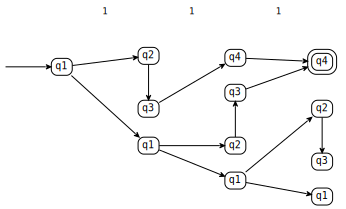

In [ ]:
run(n1, "1 1 1")

This graph (basically the same as Figure 1.29 but rotated 90 degrees) shows all the possible branches of computation. At left, we see that the machine starts in state $q_1$. Upon reading the first symbol (`1`), it goes to state $q_1$ *and* $q_2$. Moreover, from state $q_2$, it can go immediately to state $q_3$ without reading any input.

In order for an NFA to accept a string, only one path needs to accept it. In the above example, the NFA accepts the string because at least one branch of computation is in state $q_4$ at the end of the string. The other paths can dead-end, or they can even loop forever.

More example NFAs from the book:

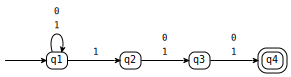

In [ ]:
n2 = read_csv('nfa-n2.csv')
n2

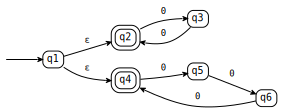

In [ ]:
n3 = read_csv('nfa-n3.csv')
n3

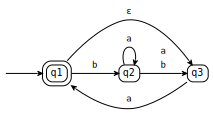

In [ ]:
n4 = read_csv('nfa-n4.csv')
n4

**Exercise.**

a. Write an NFA that recognizes the language $\{u \texttt{000} v \mid u, v \in \{\texttt{0}, \texttt{1}\}^\ast\}$, that is, it accepts all bitstrings containing three zeros.

b. Last time, we saw how, if a DFA recognizes language $L$, then flipping the accept and non-accept states causes it to recognize $\overline{L}$. Do the same thing to your NFA and see what language it recognizes. What happened?

## Formal definition

Let $\Sigma_\varepsilon = \Sigma \cup \{\varepsilon\}$. (It would be more Unixy to write this as $\Sigma^?$ but let's stick with the book's notation.)

An NFA is a tuple $(Q, \Sigma, \delta, s, F)$, where

- $Q$, $\Sigma$, $s$, and $F$ are as in the definition of DFAs.
- $\delta : Q \times \Sigma_\varepsilon \rightarrow \mathcal{P}(Q)$ is the *transition function*.

$\mathcal{P}(Q)$, the *power set* of $Q$, is the set of all subsets of $Q$. So $\delta$ takes two arguments: the first is a state and the second is a symbol or $\varepsilon$. And it returns a set of states.

## Equivalence with DFA

NFAs seem like they might be a lot more powerful than DFAs, in the sense that they might accept more languages than DFAs do. (Note: the question is not whether NFAs can accept more *strings*, because we can design either a DFA or a NFA that accepts all strings. The question is whether NFAs can accept more *languages*.) Perhaps surprisingly, the answer is no.

Any NFA can be converted to an equivalent DFA by what is commonly known as the *subset construction*. The idea is that the DFA uses its state to keep track of all the states the NFA is in at any point in time.

### By example

Recall our example NFA $N_4$:

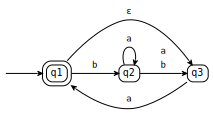

In [ ]:
n4

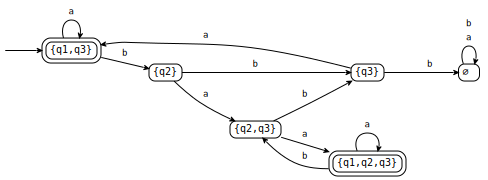

In [ ]:
d4 = determinize(n4)
to_graph(d4)

To see how this works, it may be clearer to first run both $N_4$ and its determinized version on an example string. Do you see how they relate to each other?

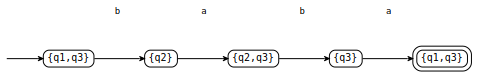

In [ ]:
run(d4, "b a b a")

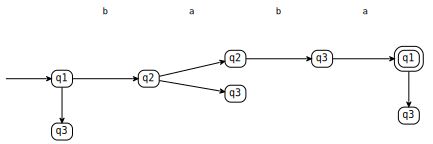

In [ ]:
run(n4, "b a b a")

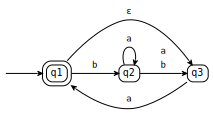

In [ ]:
n4

Each state of $D_4$ is a subset of the states of $N_4$. Let's call the states of $D_4$ *state-sets* to help distinguish them from states of $N_4$.

The start state-set of $D_4$ contains $q_1$ because it's the start state of $N_4$, and it also contains $q_3$ because $N_4$ has an $\varepsilon$-transition from $q_1$ to $q_3$. (If $q_3$ had an $\varepsilon$-transition too, we'd follow that, too.)

Next, look at state-set $\{q_1, q_3\}$. What states can be reached from any of these states on symbol $\texttt{a}$? We can reach $q_1$ and (via $\varepsilon$-transitions) $q_3$, so we add a transition from $\{q_1, q_3\}$ to itself.

What states can be reached from $\{q_1, q_3\}$ on symbol $\texttt{b}$? Just $q_2$, so we add a transition from $\{q_1, q_3\}$ to $\{q_2\}$.

Repeat this until every state-set has a transition for every symbol.

The accepting state-sets are those that contain $q_1$.

**Exercise.**

(a) Determinize your NFA for $\{u \texttt{000} v \mid u, v \in \{\texttt{0}, \texttt{1}\}^\ast\}$ using the above construction. Does the result look like how you'd write a program to search for $\texttt{000}$?

(b) Think about searching for a more complex pattern like $p = \texttt{001002}$ in a string like $w = \texttt{001001002}$. The simple algorithm would take time $O(|p||w|)$, but there's [a way to do it](https://en.wikipedia.org/wiki/Knuth–Morris–Pratt_algorithm) in time $O(|w|)$. How would you do it using automata?

### Formal definition

The book wisely defines the construction assuming no $\varepsilon$-transitions first. Given a NFA $N = (Q, \Sigma, \delta, s, F)$ without $\varepsilon$-transitions, we can construct a DFA $M'$ that recognizes $\mathcal{L}(N)$.

The states of $M'$ are subsets of $Q$. To avoid confusion, we call them state-sets.

The start state-set is $\{s\}$.

The transitions are constructed as follows: For every state-set $\bar{q} \subseteq Q$, for every $q \in \bar{q}$, for every transition in $N$ from $q$ on symbol $a$ to $r$, add $r$ to $\delta'(\bar{q}, a)$.

Finally, a state-set is accepting if it contains an element of $F$.

More formally,
\begin{align}
M' &= (\mathcal{P}(Q), \Sigma, \delta', \{s\}, F') \\
F' &= \{ \bar{q} \subseteq Q \mid \bar{q} \cap F \neq \emptyset \} \\
\delta'(\bar{q}, a) &= \bigcup_{q \in \bar{q}} \delta(q, a).
\end{align}

Now the general case: Let $N = (Q, \Sigma, \delta, s, F)$ be any NFA. If $\bar{q} \subseteq Q$ is a set of states, define $E(\bar{q})$, the $\varepsilon$-closure of $\bar{q}$, to be the set of states reachable from a state in $\bar{q}$ via 0 or more $\varepsilon$-transitions. More formally, $E(\bar{q})$ is the smallest set such that
- $\bar{q} \subseteq E(\bar{q})$.
- If $q \in E(\bar{q})$, then $\delta(q, \varepsilon) \subseteq E(\bar{q})$.

Then construct $M'$ as above, and then a DFA $M''$:
\begin{align}
M'' &= (\mathcal{P}(Q), \Sigma, \delta'', E(\{s\}), F') \\
\delta''(\bar{q}, a) &= E(\delta'(q, a)).
\end{align}
Then $M''$ recognizes $\mathcal{L}(N)$. We omit a proof of correctness.